# Customer Churn - Modeling

## Imports

In [505]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from pprint import pprint
import xgboost as xgb

## Read in data 

In [506]:
df = pd.read_csv('data/processed/customer_churn_fe.csv')
#df.head()
#df.info()

## Logistic Regression

First, we will a baseline model - the logistic regression to get a fundamental understanding of our data and how well our a baseline model performs with it.

### Split variables 

In [507]:
# split into x and y variables

# target variable - churn
y = df['Churn']

# x variables
X = df.drop(columns='Churn')

#print("\nTarget variable:")
#print(y.head())

#print("\nX variables:")
#X.head()
#X.info()

In [508]:

from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [509]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=23)

scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

### Fit model

In [510]:
# instantiate the model
log_model = LogisticRegression(class_weight='balanced', random_state=23)
log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)


### Confusion Matrix

In [511]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[829 208]
 [152 881]]


Text(50.722222222222214, 0.5, 'Actual label')

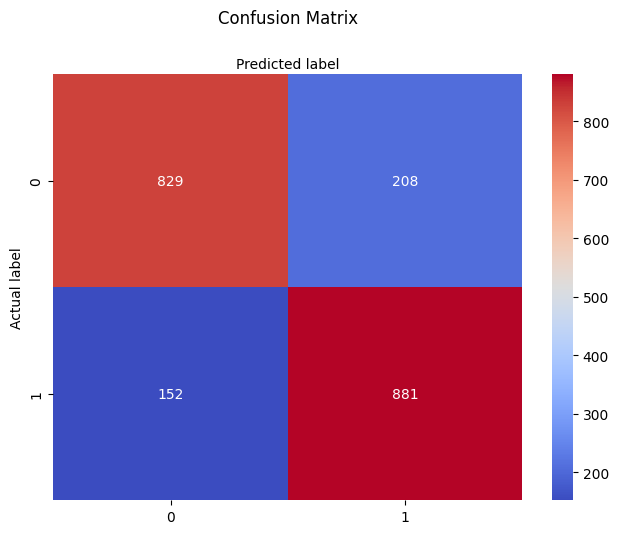

In [512]:
# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

### Classification Report

In [513]:
target_names = ["no churn", "churn"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.85      0.80      0.82      1037
       churn       0.81      0.85      0.83      1033

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



### Area Under the Curve

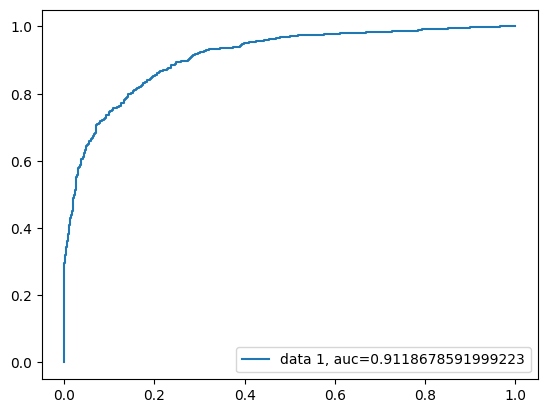

In [514]:
y_pred_prob = log_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Random Forest Classifier

### Fit model

In [515]:
rf = RandomForestClassifier(class_weight='balanced', random_state=23)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### Confusion Matrix

In [516]:
rf_cnf_matrix = confusion_matrix(y_test,y_pred)
print(rf_cnf_matrix)

[[642 395]
 [ 64 969]]


### Classification Report

In [517]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      1037
           1       0.71      0.94      0.81      1033

    accuracy                           0.78      2070
   macro avg       0.81      0.78      0.77      2070
weighted avg       0.81      0.78      0.77      2070



### Hyperparameter Tuning

Key Parameters:
* n_estimators: the amount of trees in our random forest
* max_depth: max number of levels in the trees
* min_samples_split: min number of samples required to split a node (helps prevent overfitting)

In [518]:
param_grid = {
    'n_estimators': [100, 300, 500, 800],  # Number of trees
    'max_depth': [10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples for node split
    'min_samples_leaf': [1, 2, 4],  # Min samples in leaf
    'max_features': ['sqrt', 'log2'],  # Features per tree
    'bootstrap': [True, False]  # Sampling method
}

rf = RandomForestClassifier(class_weight='balanced',random_state=23)
rf_random = RandomizedSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_iter=50, 
    n_jobs=-1)

rf_random.fit(X_train, y_train)

print("\nBest parameters found:")
pprint(rf_random.best_params_)
print(f"\nBest cross validation score: {rf_random.best_score_:.4f}")


Best parameters found:
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Best cross validation score: 0.9204


### Run Tuned Random Forest Model

In [519]:
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

### New Confusion Matrix

Text(50.722222222222214, 0.5, 'Actual label')

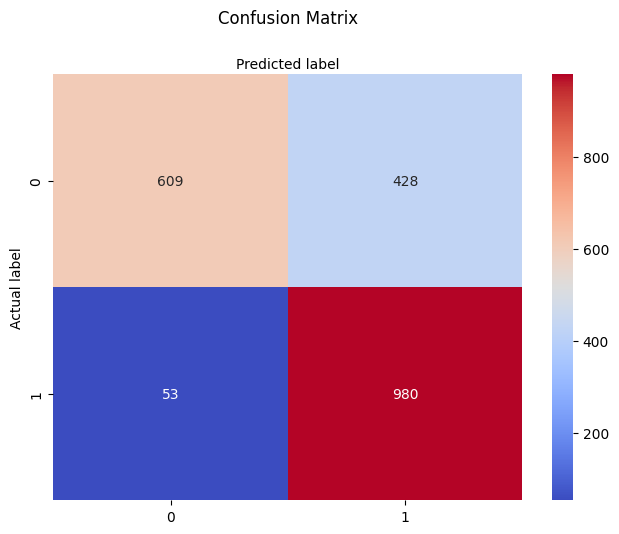

In [520]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

### New Classification Report

In [521]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.59      0.72      1037
           1       0.70      0.95      0.80      1033

    accuracy                           0.77      2070
   macro avg       0.81      0.77      0.76      2070
weighted avg       0.81      0.77      0.76      2070



## Check for overfitting

### Logistic Regression

In [530]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Predictions on training and test sets
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

# AUC-ROC scores
train_auc = roc_auc_score(y_train, log_model.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
print("\nAUC-ROC Train:", train_auc)
print("AUC-ROC Test:", test_auc)

Train Accuracy: 0.8244745107513892
Test Accuracy: 0.8260869565217391

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      4137
           1       0.82      0.84      0.83      4141

    accuracy                           0.82      8278
   macro avg       0.82      0.82      0.82      8278
weighted avg       0.82      0.82      0.82      8278


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      1037
           1       0.81      0.85      0.83      1033

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070


AUC-ROC Train: 0.9101263201188795
AUC-ROC Test: 0.9118678591999223


### Random Forest

In [527]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Predictions on training and test sets
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# AUC-ROC scores
train_auc = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
print("\nAUC-ROC Train:", train_auc)
print("AUC-ROC Test:", test_auc)

Train Accuracy: 0.9736651365064025
Test Accuracy: 0.7676328502415459

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      4137
           1       0.96      0.99      0.97      4141

    accuracy                           0.97      8278
   macro avg       0.97      0.97      0.97      8278
weighted avg       0.97      0.97      0.97      8278


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.92      0.59      0.72      1037
           1       0.70      0.95      0.80      1033

    accuracy                           0.77      2070
   macro avg       0.81      0.77      0.76      2070
weighted avg       0.81      0.77      0.76      2070


AUC-ROC Train: 0.9980671363445087
AUC-ROC Test: 0.9000999793693364


## XGBoost Binary Classifier

In [524]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [525]:
y_pred = xgb_model.predict(X_test)
print(y_pred)

[0 1 0 ... 1 1 0]


In [526]:
# evaluate predictions
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.27      0.42      1037
           1       0.57      0.98      0.72      1033

    accuracy                           0.62      2070
   macro avg       0.75      0.63      0.57      2070
weighted avg       0.75      0.62      0.57      2070

